# Tutorial: projection onto the Generalized Minkowski Set

[GeneralizedMinkowskiSets documentation main](https://petersbas.github.io/GeneralizedMinkowskiSetDocs/)

This is a tutorial on how to use the [SetIntersectionProjection](https://github.com/slimgroup/SetIntersectionProjection.jl) software can be used to compute the projection of a vectorized 2D and 3D image/model ($m \in \mathbb{R}^N$) onto a generalization of the Minkowski set:

$$\mathcal{M} \equiv \{ m = u + v \: \mid \: u \in \bigcap_{i=1}^p \mathcal{D}_i, \: v \in \bigcap_{j=1}^q \mathcal{E}_j, \: m \in \bigcap_{k=1}^r \mathcal{F}_k \}$$

The vector $m$ is an element of the generalized Minkowski set if $m$ is an element of the intersection of $r$ sets $\mathcal{F}_k$ and also the sum of two
components $u \in \mathbb{R}^N$ and $v \in \mathbb{R}^N$. The vector $u$
is an element of the intersection of $p$ sets $\mathcal{D}_i$ and $v$ is an
element of the intersection of $q$ sets $\mathcal{E}_j$.

In this tutorial, we will project a 2D image (geological model) onto the Generalized Minkowski set that is constructed from the sets

\begin{align}
&\mathcal{F}_1 = \{ m \mid 1500 \leq m \leq 4500 \} \\
&\mathcal{D}_1 = \{ u \mid 1500 \leq u \leq 4500 \} \\
&\mathcal{D}_2 = \{ u \mid 0 \leq (D_z \otimes I_x)u \leq \infty\} \\
&\mathcal{E}_1 = \{ v \mid -500 \leq v \leq 500 \} \\
&\mathcal{E}_2 = \{ v \mid \operatorname{rank}(v) \leq 20 \}. \\
\end{align}

That is, we solve the projection problem
$$\min_{x} \frac{1}{2} \| x - m \|_2^2 \quad \text{s.t} \quad m \in \mathcal{F}_1 \bigcap \bigg(\bigcap_{i=1}^2 \mathcal{D}_i + \bigcap_{j=1}^2 \mathcal{E}_j \bigg)$$

The result is: one component that is within certain bounds and has parameter values that monotonically increase in the 'z' coordinate (depth/vertical); another component that is within certain bounds and has a low-rank; and the sum of these two components that approximates the original image/model.

The motivation for these constraint types is the following: the p-wave velocity in the earth generally increases with depth. However, in the near-surface there are many localized deviations. Also, in this example of sedimentary geology, the layers in the earth are approximately horizontal and show slow lateral variation. The first component thus segments the monotonically increasing velocity structure with depth, and the second component extracts the localized deviations but also adheres to the sedimentary structure.

Because the software is based on [SetIntersectionProjection.jl](https://github.com/slimgroup/SetIntersectionProjection.jl), it may be useful to have a look at the [documentation](https://petersbas.github.io/SetIntersectionProjectionDocs/). Note that this notebook is for Julia 1.5

In [ ]:
# May need to uncomment the lines below for new environment
# using Pkg
# Pkg.activate(".")
# Pkg.instantiate()

using SetIntersectionProjection
using MAT
using LinearAlgebra

mutable struct compgrid #define a computational grid information type
  d :: Tuple #spacing between grid points in each direction
  n :: Tuple #number of grid points in each direction
end

#PARSDMM options:
options    = PARSDMM_options() #get and fill all options with defaults
options.FL = Float32 
#other options include
    #   x_min_solver          :: String       = "CG_normal" #what algorithm to use for the x-minimization (CG applied to normal equations)
    #   maxit                 :: Integer      = 200         #max number of PARSDMM iterations
    #   evol_rel_tol          :: Real         = 1e-3        #stop PARSDMM if ||x^k - X^{k-1}||_2 / || x^k || < options.evol_rel_tol AND options.feas_tol is reached
    #   feas_tol              :: Real         = 5e-2        #stop PARSDMM if the transform-domain relative feasibility error is < options.feas_tol AND options.evol_rel_tol is reached
    #   obj_tol               :: Real         = 1e-3        #optional stopping criterion for change in distance from point that we want to project
    #   rho_ini               :: Vector{Real} = [10.0]      #initial values for the augmented-Lagrangian penalty parameters. One value in array or one value per constraint set in array
    #   rho_update_frequency  :: Integer      = 2           #update augmented-Lagrangian penalty parameters and relaxation parameters every X number of PARSDMM iterations
    #   gamma_ini             :: Real         = 1.0         #initial value for all relaxation parameters (scalar)
    #   adjust_rho            :: Bool         = true        #adapt augmented-Lagrangian penalty parameters or not
    #   adjust_gamma          :: Bool         = true        #adapt relaxation parameters in PARSDMM
    #   adjust_feasibility_rho:: Bool         = true        #adapt augmented-Lagrangian penalty parameters based on constraint set feasibility errors (can be used in combination with options.adjust_rho)
    #   Blas_active           :: Bool         = true        #use direct BLAS calls, otherwise the code will use Julia loop-fusion where possible
    #   feasibility_only      :: Bool         = false       #drop distance term and solve a feasibility problem
    #   FL                    :: DataType     = Float32     #type of Float: Float32 or Float64
    #   parallel              :: Bool         = false       #compute proximal mappings, multiplier updates, rho and gamma updates in parallel
    #   zero_ini_guess        :: Bool         = true        #zero initial guess for primal, auxiliary, and multipliers

#select working precision
if options.FL==Float64
  TF = Float64
elseif options.FL==Float32
  TF = Float32
end

#load image to project
file = matopen(joinpath(dirname(pathof(SetIntersectionProjection)), "../examples/Data/compass_velocity.mat"))
m    = read(file, "Data");close(file)
m    = m[1:341,200:600]
m    = permutedims(m,[2,1])

#set up computational grid (25 and 6 m are the original distances between grid points)
comp_grid = compgrid((TF(25.0), TF(6.0)),(size(m,1), size(m,2))) #set up as compgrid( (dx,dz) , (nx,nz) ) in 2D, in 3D use compgrid( (dx, dy, dz) , (nx, ny, nz) )
#use as comp_grid.n and comp_grid.d

m = convert(Vector{TF},vec(m)) #PARSDMM needs the 2D/3D model as a vector, also convert to the desired precision

Set other performance related items that are not `SetIntersectionProjection` options. `SetIntersectionProjection` solution times will be affected by these. Do not forget start Julia with multiple threads for speedup, e.g., `/Applications/Julia-1.5.app/Contents/Resources/julia/bin/julia --threads 2` on a Mac.

In [5]:
set_zero_subnormals(true)
BLAS.set_num_threads(2)

Now we are ready to define multiple constraints for the model, as well as for each of the two components in the Generalized Minkowsi set.

First we define constraints for the model parameters itself (the sum of the two components).

In [6]:
#constraints for total model
constraint_sum = Vector{SetIntersectionProjection.set_definitions}() #Initialize constraint information structures

#bounds:
m_min     = 1500.0
m_max     = 4500.0
set_type  = "bounds"
TD_OP     = "identity"
app_mode  = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint_sum, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP));

Second, we define constraints for component 1. We use bound constraints and monotonically increasing parameter values in the vertical direction.

In [7]:
#constraints for component 1 of the model
constraint_c1 = Vector{SetIntersectionProjection.set_definitions}()

#bounds component 1:
m_min          = 1500f0*ones(TF,prod(comp_grid.n))
m_max          = 4500f0.*ones(TF,comp_grid.n)
m_max[:,1:35] .= 1500f0
m_max     = vec(m_max)
set_type  = "bounds"
TD_OP     = "identity"
app_mode  = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint_c1, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

#slope constraints component 1(vertical)
m_min     = 0.0
m_max     = 1e6
set_type  = "bounds"
TD_OP     = "D_z"
app_mode  = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint_c1, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP));

Now we define the constraints for the second component. We use bounds and low-rank constraints.

In [8]:
#constraints for component 2 of the model
constraint_c2 = Vector{SetIntersectionProjection.set_definitions}()

#bounds component 2:
m_min     = -500.0
m_max     = 500.0
set_type  = "bounds"
TD_OP     = "identity"
app_mode  = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint_c2, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

#rank constraint component 2
m_min     = 0
m_max     = 20
set_type  = "rank"
TD_OP     = "identity"
app_mode  = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint_c2, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP));

So far, we defined what constraints we would like to use. The next step is to use the provide scripts to generate constraint set information, projectors, and linear operators.

In [9]:
options.parallel       = false #indicate we are working in serial (1 Julia worker, but still use multi-threading)

#get projectors onto simple sets, linear operators, set information
#get these items for each component and the sum of the two components
(P_sub_sum,TD_OP_sum,set_Prop_sum) = setup_constraints(constraint_sum,comp_grid,options.FL)
(P_sub_c1,TD_OP_c1,set_Prop_c1)    = setup_constraints(constraint_c1,comp_grid,options.FL)
(P_sub_c2,TD_OP_c2,set_Prop_c2)    = setup_constraints(constraint_c2,comp_grid,options.FL);

Some properties of each set are stored in `set_Prop_c1`. For example, we can see if set number 2 is non-convex using `set_Prop_c1.ncvx[2]`. To see what set number 2 is, as generated by our scripts above, we can use `set_Prop_c1.tag[2]`, which returns a tuple of (constraint type, linear operator description, application mode, application direction if applicable).

In [ ]:
# ncvx       ::Vector{Bool}                                          #is the set non-convex? (true/false)
# AtA_diag   ::Vector{Bool}                                          #is A^T A a diagonal matrix?
# dense      ::Vector{Bool}                                          #is A a dense matrix?
# TD_n       ::Vector{Tuple}                                         #the grid dimensions in the transform-domain.
# tag        ::Vector{Tuple{String,String,String,String}}            #(constraint type, linear operator description, application mode,application direction if applicable)
# banded     ::Vector{Bool}                                          #is A a banded matrix?
# AtA_offsets::Union{Vector{Vector{Int32}},Vector{Vector{Int64}}}    #only required if A is banded. A vector of indices of the non-zero diagonals, where the main diagonal is index 0

Now we have projectors onto simple sets and linear operators, for each component and the sum separately. We'll run a script to unify and generate input for the PARSDMM algorithm. The code block below also precomputes certain quantities and distributes things over julia workers if we were to use it in parallel mode

In [11]:
options.Minkowski        = true #do not forget to set this flag to true!
#precompute and distribute quantities once, reuse later
(TD_OP,set_Prop,AtA,l,y) = PARSDMM_precompute_distribute_Minkowski(TD_OP_c1,TD_OP_c2,TD_OP_sum,set_Prop_c1,set_Prop_c2,set_Prop_sum,comp_grid,options);

We now put all our function calls to projectors in one vector.

In [12]:
P_sub = deepcopy(P_sub_c1);
append!(P_sub,P_sub_c2)
append!(P_sub,P_sub_sum);

We are ready to solve the projection problem onto the generalized Minkowski sum, using the projectors and linear operators generated as above, or using your own.

In [ ]:
#project onto Generalized Minkowski Set, twice to get accurate timing
@time (x,log_PARSDMM) = PARSDMM(m,AtA,TD_OP,set_Prop,P_sub,comp_grid,options);
@time (x,log_PARSDMM) = PARSDMM(m,AtA,TD_OP,set_Prop,P_sub,comp_grid,options);

Let's plot the results (this example uses PyPlot)

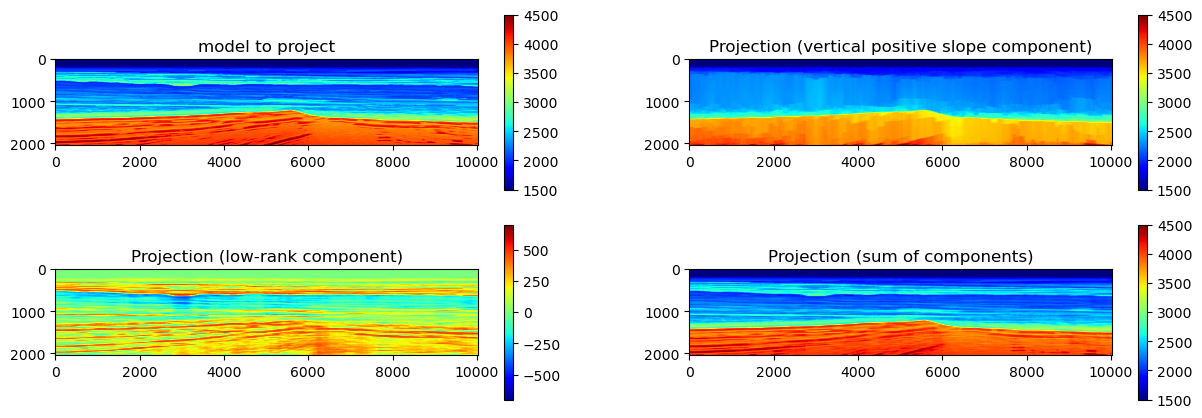

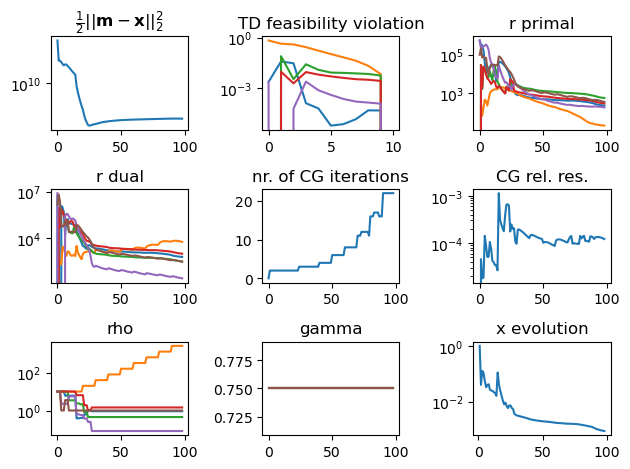

In [17]:
using PyPlot

m1 = x[1:length(m)]     #component 1
m2 = x[1+length(m):end] #component 2
ms = m1+m2;             #sum of components

#define axis limits and colorbar limits
xmax = comp_grid.d[1]*comp_grid.n[1]
zmax = comp_grid.d[2]*comp_grid.n[2]
vmi  = 1500
vma  = 4500

figure(figsize=(15,5));
subplot(2,2,1);imshow(permutedims(reshape(m,(comp_grid.n[1],comp_grid.n[2])),[2,1]),cmap="jet",vmin=vmi,vmax=vma,extent=[0,  xmax, zmax, 0]);colorbar(); title("model to project")
#savefig("original_model.png",bbox_inches="tight")
subplot(2,2,2);imshow(permutedims(reshape(m1,(comp_grid.n[1],comp_grid.n[2])),[2,1]),cmap="jet",vmin=vmi,vmax=vma,extent=[0,  xmax, zmax, 0]);colorbar(); title("Projection (vertical positive slope component)")
#savefig("projected_model_component1.png",bbox_inches="tight")
subplot(2,2,3);imshow(permutedims(reshape(m2,(comp_grid.n[1],comp_grid.n[2])),[2,1]),cmap="jet",vmin=-700,vmax=700,extent=[0,  xmax, zmax, 0]);colorbar(); title("Projection (low-rank component)")
#savefig("projected_model_component2.png",bbox_inches="tight")
subplot(2,2,4);imshow(permutedims(reshape(ms,(comp_grid.n[1],comp_grid.n[2])),[2,1]),cmap="jet",vmin=vmi,vmax=vma,extent=[0,  xmax, zmax, 0]);colorbar(); title("Projection (sum of components)")
#savefig("projected_model_sum_components.png",bbox_inches="tight")

figure();
subplot(3, 3, 3);semilogy(log_PARSDMM.r_pri)          ;title("r primal")
subplot(3, 3, 4);semilogy(log_PARSDMM.r_dual)         ;title("r dual")
subplot(3, 3, 1);semilogy(log_PARSDMM.obj)            ;title(L"$ \frac{1}{2} || \mathbf{m}-\mathbf{x} ||_2^2 $")
subplot(3, 3, 2);semilogy(log_PARSDMM.set_feasibility);title("TD feasibility violation")
subplot(3, 3, 5);plot(log_PARSDMM.cg_it)              ;title("nr. of CG iterations")
subplot(3, 3, 6);semilogy(log_PARSDMM.cg_relres)      ;title("CG rel. res.")
subplot(3, 3, 7);semilogy(log_PARSDMM.rho)            ;title("rho")
subplot(3, 3, 8);plot(log_PARSDMM.gamma)              ;title("gamma")
subplot(3, 3, 9);semilogy(log_PARSDMM.evol_x)         ;title("x evolution")
tight_layout()
#tight_layout(pad=0.0, w_pad=0.0, h_pad=1.0)
#savefig("PARSDMM_logs.png",bbox_inches="tight")


#A model, its projection onto the generalized Minkowski set, as well as various diagnostics from the PARSDMM algorithm.